## 1. Introduction
<p><a href="https://commons.wikimedia.org/wiki/File:Tux.svg">
<img style="float: right;margin:5px 20px 5px 1px" width="150px" src="https://assets.datacamp.com/production/project_111/img/tux.png" alt="Tux - the Linux mascot">
</a></p>
<p>Version control repositories like CVS, Subversion or Git can be a real gold mine for software developers. They contain every change to the source code including the date (the "when"), the responsible developer (the "who"), as well as a little message that describes the intention (the "what") of a change.</p>
<p>In this notebook, we will analyze the evolution of a very famous open-source project &ndash; the Linux kernel. The Linux kernel is the heart of some Linux distributions like Debian, Ubuntu or CentOS. Our dataset at hand contains the history of kernel development of almost 13 years (early 2005 - late 2017). We get some insights into the work of the development efforts by </p>
<ul>
<li>identifying the TOP 10 contributors and</li>
<li>visualizing the commits over the years.</li>
</ul>

## 2. Reading in the dataset
<p>The dataset was created by using the command <code>git log --no-merges --no-renames --date=raw --encoding=latin-1 --pretty="%at#%aN"</code> in early 2021. The <code>latin-1</code> encoded text output was saved in a header-less CSV file. In this file, each row is a commit entry with the following information:</p>
<ul>
<li><code>timestamp</code>: the time of the commit as a UNIX timestamp in seconds since 1970-01-01 00:00:00 (Git log placeholder "<code>%at</code>")</li>
<li><code>author</code>: the name of the author that performed the commit (Git log placeholder "<code>%aN</code>")</li>
</ul>
<p>The columns are separated by the number sign <code>#</code>. The complete dataset is in the <code>datasets/</code> directory. It is a <code>gz</code>-compressed csv file named <code>git_log.gz</code>.</p>
<p>Let's take a quick look at the dataset in question.</p>  

In [10]:
import pandas as pd

git_log = pd.read_csv('datasets/git_log.gz', compression='gzip', sep='#',encoding='latin-1',header=None,names=['timestamp', 'author'])
git_log.head()

,timestamp,author
0,1615977947,Leon Romanovsky
1,1607367181,Manaf Meethalavalappu Pallikunhi
2,1615909515,Paul Cercueil
3,1615473066,Filipe Manana
4,1615473065,Filipe Manana


## 3. Getting an overview
<p>The dataset contains the information about every single code contribution (a "commit") to the Linux kernel over the last 15 years. We'll first take a look at the number of authors and their commits to the repository.</p>

In [2]:
number_of_commits = git_log.shape[0]
number_of_authors = len(git_log.loc[~git_log['author'].isna(), 'author'].unique())
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

23032 authors committed 923209 code changes.


## 4. Finding the TOP 10 contributors
<p>There are some very important people that changed the Linux kernel very often. To see if there are any bottlenecks, we take a look at the TOP 10 authors with the most commits.</p>

In [3]:
top_10_authors = git_log['author'].value_counts()[:10]
print(top_10_authors)

Mauro Carvalho Chehab    7374
Al Viro                  7022
Christoph Hellwig        6838
Takashi Iwai             6596
Chris Wilson             6325
H Hartley Sweeten        5942
Thomas Gleixner          5286
Arnd Bergmann            5089
Geert Uytterhoeven       4820
Johannes Berg            4717
Name: author, dtype: int64


## 5. Wrangling the data
<p>For our analysis, we want to visualize the contributions over time. For this, we use the information in the <code>timestamp</code> column to create a time series-based column.</p>

In [4]:
git_log['timestamp'] = pd.to_datetime(git_log['timestamp'], unit='s')
git_log['timestamp'].describe()

count                  923209
unique                 885983
top       2017-10-31 17:56:19
freq                      137
first     1970-01-01 00:00:01
last      2085-06-18 15:57:19
Name: timestamp, dtype: object

## 6. Treating wrong timestamps
<p>As we can see from the results above, some contributors had their operating system's time incorrectly set when they committed to the repository. We assume that Linus Torvalds was the first contributor so his first commit should be the first real timestamp and we take the end of 2020 as the latest boundary. We'll clean up the <code>timestamp</code> column by dropping the rows with the incorrect timestamps.</p>

In [6]:
# determining the first real commit timestamp
linus_sorted = git_log[git_log['author'] == 'Linus Torvalds'].sort_values(by='timestamp')
first_commit_timestamp = linus_sorted.iloc[0,0]

# determining the last sensible commit timestamp
pre_2018_sorted = git_log[git_log['timestamp'] < '2018-01-01'].sort_values(by='timestamp', ascending=False)
last_commit_timestamp = pre_2018_sorted.iloc[0,0]

# filtering out wrong timestamps
corrected_log = git_log[(git_log['timestamp'] >= first_commit_timestamp) & (git_log['timestamp'] <= last_commit_timestamp)]

# summarizing the corrected timestamp column
corrected_log.describe()

,timestamp,author
count,679493,679492
unique,648514,18039
top,2017-10-31 17:56:19,Al Viro
freq,137,6062
first,2005-04-16 22:20:36,NaN
last,2017-12-31 23:20:46,NaN


## 7. Grouping commits per year
<p>To find out how the development activity has increased over time, we'll group the commits by year and count them up.</p>

In [7]:
commits_per_year = corrected_log.groupby(pd.Grouper(key='timestamp', freq='AS')).count()
commits_per_year.head()

,author
timestamp,
2005-01-01,14959
2006-01-01,27628
2007-01-01,32165
2008-01-01,45992
2009-01-01,48864


## 8. Visualizing the history of Linux
<p>Finally, we'll make a plot out of these counts to better see how the development effort on Linux has increased over the the last few years. </p>

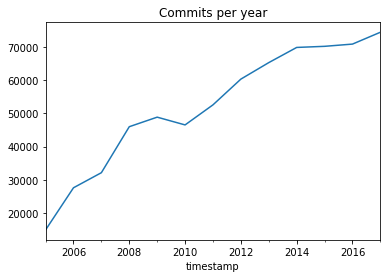

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

commits_per_year.plot(title='Commits per year', legend=0)
plt.show()

## 9.  Conclusion
<p>Thanks to the solid foundation and caretaking of Linux Torvalds, many other developers are now able to contribute to the Linux kernel as well. There is no decrease of development activity at sight!</p>

In [9]:
year_with_most_commits = corrected_log['timestamp'].dt.year.value_counts().sort_values(ascending=False).index[0]
print(year_with_most_commits)

2017
